# LSTM on Apple Dataset

Getting the data

In [1]:
import pandas as pd 
import numpy as np

In [2]:
train_apple = pd.read_csv("train_apple.csv")
test_apple = pd.read_csv("test_apple.csv")

In [3]:
train_apple.head()

,date,symbol,open,close,low,high,volume
0,2010-01-04,AAPL,213.429998,214.009998,212.380001,214.499996,123432400.0
1,2010-01-05,AAPL,214.599998,214.379993,213.249994,215.589994,150476200.0
2,2010-01-06,AAPL,214.379993,210.969995,210.750004,215.230000,138040000.0
3,2010-01-07,AAPL,211.750000,210.580000,209.050005,212.000006,119282800.0
4,2010-01-08,AAPL,210.299994,211.980005,209.060005,212.000006,111902700.0


Data Manipulation

In [4]:
#Sorting the dataset based on the date column
train_apple = train_apple.sort_values("date")
test_apple  = test_apple.sort_values("date")

#getting the dates in particular format
train_apple['date'] = train_apple['date'].astype('datetime64[D]')
test_apple['date'] = test_apple['date'].astype('datetime64[D]')

In [5]:
#getting the independent and dependent datasets
Y_train = train_apple["close"]
Y_test = test_apple["close"]


X_train = train_apple.drop(["symbol" , "close" ] , axis = 1)
X_test = test_apple.drop(["symbol" , "close" ] , axis = 1)

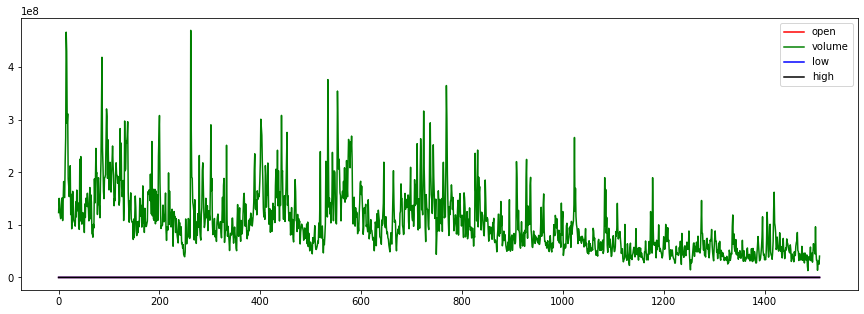

In [7]:
#Plotting the data to know some insights
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5));
plt.plot(X_train.open.values, color='red', label='open')
plt.plot(X_train.volume.values, color='green', label='volume')
plt.plot(X_train.low.values, color='blue', label='low')
plt.plot(X_train.high.values, color='black', label='high')
plt.legend(loc='best')
plt.show()

In [8]:
#Volume column does not seem to be impactful, hence dropping it
X_train = X_train.drop("volume" , axis =1)
X_test = X_test.drop("volume" , axis =1)

#Getting the date column as a feature as well
X_train['date'] = X_train['date'].dt.strftime('%Y%m%d').astype(float)
X_test['date'] = X_test['date'].dt.strftime('%Y%m%d').astype(float)

In [9]:
#Normalizing the data 
from sklearn.preprocessing import MinMaxScaler

def normalize_data(data):
    min_max_scaler = MinMaxScaler()
    data["open"] = min_max_scaler.fit_transform(data.open.values.reshape(-1,1))
    data["low"] = min_max_scaler.fit_transform(data.low.values.reshape(-1,1))
    data["high"] = min_max_scaler.fit_transform(data.high.values.reshape(-1,1))
    data["date"] = min_max_scaler.fit_transform(data.date.values.reshape(-1,1))
    
    return data

In [10]:
X_train = normalize_data(X_train)
X_test = normalize_data(X_test)

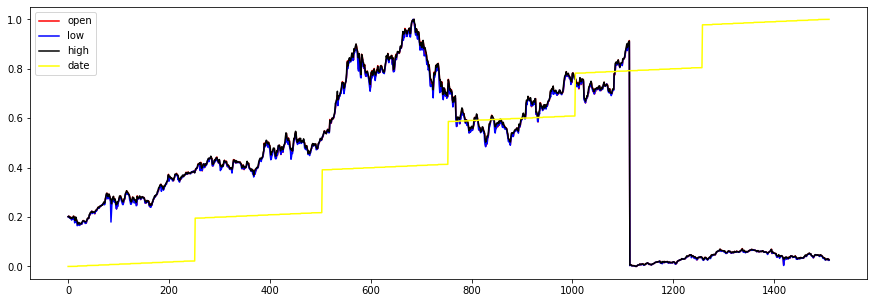

In [11]:
#Plotting again
plt.figure(figsize=(15, 5));
plt.plot(X_train.open.values, color='red', label='open')
plt.plot(X_train.low.values, color='blue', label='low')
plt.plot(X_train.high.values, color='black', label='high')
plt.plot(X_train.date.values, color='yellow', label='date')
plt.legend(loc='best')
plt.show()

In [12]:
#Data looks good. Checking the shape
print(X_train.shape , Y_train.shape)
print("="*50)
print(X_test.shape, Y_test.shape)

(1510, 4) (1510,)
(252, 4) (252,)


# LSTM modeling

In [14]:
from keras.models import Sequential
from keras.layers import Dense , Dropout
from keras.layers import LSTM , GRU
from sklearn.metrics import mean_squared_error
from keras.optimizers import Adam 

In [15]:
#getting the datasets into favourable input formats
X_train = X_train.values.reshape(X_train.shape[0] , 1 , X_train.shape[1])
X_test = X_test.values.reshape(X_test.shape[0] , 1 , X_test.shape[1])

In [17]:
# create the model
#After several trial, this model setup seems to work best 

model = Sequential()

model.add(GRU(256, input_shape = (1 , 4) , return_sequences = True))
model.add(Dropout(0.4))

model.add(LSTM(256))
model.add(Dropout(0.4))

#model.add(LSTM(128))
#model.add(Dropout(0.4))

model.add(Dense(64 ,  activation = 'relu'))
model.add(Dense(1))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 1, 256)            200448    
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 256)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 742,273
Trainable params: 742,273
Non-trainable params: 0
_________________________________________________________________
None

In [19]:
#setting the metrics and the learning rate
model.compile(loss='mean_squared_error', optimizer=Adam(lr = 0.001) , metrics = ['mean_squared_error'])

In [21]:
#Training for 150 epoches with a batch size of 128 in each epoch 
model_lstm  = model.fit(X_train, Y_train , epochs=150 , batch_size = 128 , validation_data = (X_test, Y_test))

Train on 1510 samples, validate on 252 samples
Epoch 1/150
1510/1510 [==============================] - 1s 651us/step - loss: 152171.4508 - mean_squared_error: 152171.4508 - val_loss: 10777.8229 - val_mean_squared_error: 10777.8229
Epoch 2/150
1510/1510 [==============================] - 0s 110us/step - loss: 150356.8479 - mean_squared_error: 150356.8479 - val_loss: 9671.8431 - val_mean_squared_error: 9671.8431
Epoch 3/150
1510/1510 [==============================] - 0s 94us/step - loss: 142929.5210 - mean_squared_error: 142929.5210 - val_loss: 6372.8147 - val_mean_squared_error: 6372.8147
Epoch 4/150
1510/1510 [==============================] - 0s 97us/step - loss: 123274.2529 - mean_squared_error: 123274.2529 - val_loss: 1558.3794 - val_mean_squared_error: 1558.3794
Epoch 5/150
1510/1510 [==============================] - 0s 99us/step - loss: 90999.4938 - mean_squared_error: 90999.4938 - val_loss: 930.1315 - val_mean_squared_error: 930.1315
Epoch 6/150
1510/1510 [====================

Epoch 46/150
1510/1510 [==============================] - 0s 95us/step - loss: 709.8795 - mean_squared_error: 709.8795 - val_loss: 109014.1228 - val_mean_squared_error: 109014.1228
Epoch 47/150
1510/1510 [==============================] - 0s 96us/step - loss: 738.6771 - mean_squared_error: 738.6771 - val_loss: 111695.5082 - val_mean_squared_error: 111695.5082
Epoch 48/150
1510/1510 [==============================] - 0s 91us/step - loss: 748.2951 - mean_squared_error: 748.2951 - val_loss: 110139.7178 - val_mean_squared_error: 110139.7178
Epoch 49/150
1510/1510 [==============================] - 0s 102us/step - loss: 695.6302 - mean_squared_error: 695.6302 - val_loss: 111231.7971 - val_mean_squared_error: 111231.7971
Epoch 50/150
1510/1510 [==============================] - 0s 104us/step - loss: 728.4266 - mean_squared_error: 728.4266 - val_loss: 108358.2279 - val_mean_squared_error: 108358.2279
Epoch 51/150
1510/1510 [==============================] - 0s 96us/step - loss: 704.5485 - mea

1510/1510 [==============================] - 0s 93us/step - loss: 651.4237 - mean_squared_error: 651.4237 - val_loss: 109405.5474 - val_mean_squared_error: 109405.5474
Epoch 92/150
1510/1510 [==============================] - 0s 83us/step - loss: 636.1342 - mean_squared_error: 636.1342 - val_loss: 113355.5119 - val_mean_squared_error: 113355.5119
Epoch 93/150
1510/1510 [==============================] - 0s 99us/step - loss: 599.1362 - mean_squared_error: 599.1362 - val_loss: 110662.0382 - val_mean_squared_error: 110662.0382
Epoch 94/150
1510/1510 [==============================] - 0s 94us/step - loss: 664.5532 - mean_squared_error: 664.5532 - val_loss: 109363.2887 - val_mean_squared_error: 109363.2887
Epoch 95/150
1510/1510 [==============================] - 0s 91us/step - loss: 685.3055 - mean_squared_error: 685.3055 - val_loss: 112513.9268 - val_mean_squared_error: 112513.9268
Epoch 96/150
1510/1510 [==============================] - 0s 94us/step - loss: 648.8726 - mean_squared_error

1510/1510 [==============================] - 0s 92us/step - loss: 562.8715 - mean_squared_error: 562.8715 - val_loss: 109637.7386 - val_mean_squared_error: 109637.7386
Epoch 137/150
1510/1510 [==============================] - 0s 86us/step - loss: 621.2173 - mean_squared_error: 621.2173 - val_loss: 113875.5216 - val_mean_squared_error: 113875.5216
Epoch 138/150
1510/1510 [==============================] - 0s 98us/step - loss: 620.6111 - mean_squared_error: 620.6111 - val_loss: 107565.3462 - val_mean_squared_error: 107565.3462
Epoch 139/150
1510/1510 [==============================] - 0s 91us/step - loss: 656.2641 - mean_squared_error: 656.2641 - val_loss: 111879.5340 - val_mean_squared_error: 111879.5340
Epoch 140/150
1510/1510 [==============================] - 0s 86us/step - loss: 592.2503 - mean_squared_error: 592.2503 - val_loss: 114624.8780 - val_mean_squared_error: 114624.8780
Epoch 141/150
1510/1510 [==============================] - 0s 89us/step - loss: 625.7886 - mean_squared_

In [22]:
#getting the model MSE and RMS value
import math 

def model_score(model, X_train, Y_train, X_test, Y_test):
    trainScore = model.evaluate(X_train, Y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))
    testScore = model.evaluate(X_test, Y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

model_score(model, X_train, Y_train, X_test, Y_test)

Train Score: 27.88001 MSE (5.28 RMSE)
Test Score: 112805.29439 MSE (335.86 RMSE)


(27.880009799603595, 112805.29439484127)

In [23]:
y_pred = model.predict(X_test)

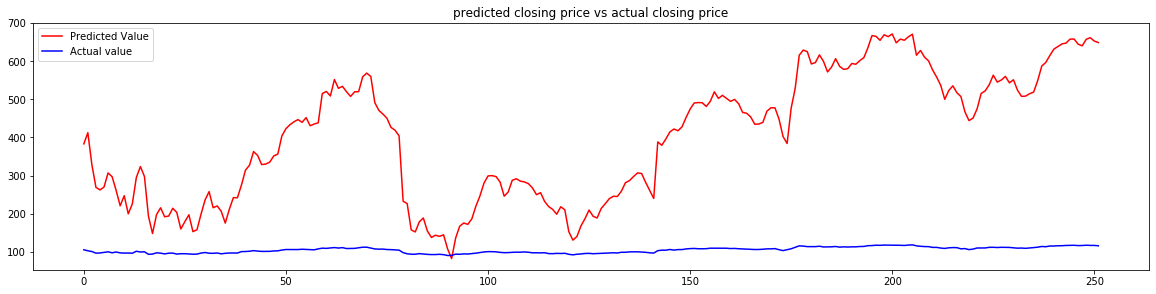

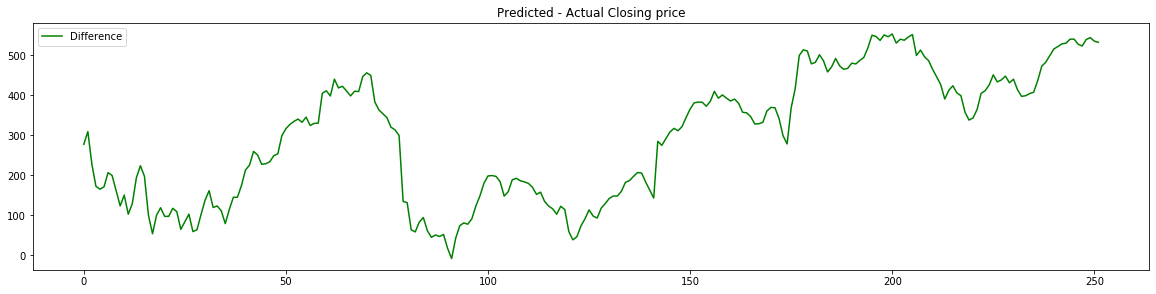

In [35]:
#Plotting the actual vs the predicted closing price values
#Plotting the difference between the predicted and the actual value
from pylab import *

figure(figsize=(20,10))
subplot(2,1,1)
title('predicted closing price vs actual closing price')
plot(y_pred , color = 'r' , label = 'Predicted Value')
plot(Y_test , color = 'b' , label = 'Actual value')
legend()

figure(figsize=(20,10))
subplot(2,1,2)
title('Predicted - Actual Closing price')
plot(y_pred.flatten()-Y_test , color = 'g' , label = 'Difference')

legend()
show()

# LSTM model with slight changes in the dataset

Getting the data again but this time will make slight adjustments 

In [36]:
train_apple.head()

,date,symbol,open,close,low,high,volume
0,2010-01-04,AAPL,213.429998,214.009998,212.380001,214.499996,123432400.0
1,2010-01-05,AAPL,214.599998,214.379993,213.249994,215.589994,150476200.0
2,2010-01-06,AAPL,214.379993,210.969995,210.750004,215.230000,138040000.0
3,2010-01-07,AAPL,211.750000,210.580000,209.050005,212.000006,119282800.0
4,2010-01-08,AAPL,210.299994,211.980005,209.060005,212.000006,111902700.0


In [37]:
train_apple = train_apple.sort_values("date")
test_apple  = test_apple.sort_values("date")

train_apple['date'] = train_apple['date'].astype('datetime64[D]')
test_apple['date'] = test_apple['date'].astype('datetime64[D]')

In [38]:
#Dropping all columns except the date and the opening price
train_apple = train_apple.drop(["symbol"  , "low" , "high" , "volume" ] , axis = 1)
test_apple = test_apple.drop(["symbol" , "low" , "high" , "volume"] , axis = 1)

In [39]:
#idea - We will take date, opening price and for a particular day, it's past 2 days closing values

def get_new_data(dataset):
    
    #last day closing price
    
    dataset.loc[0,'close_1'] = dataset.loc[0,'open']
    
    for i in range(1,len(dataset)):
        dataset.loc[i,'close_1'] = dataset.loc[i-1,'close']
    
    #Last to last day closing price
    
    dataset.loc[0,'close_2'] = dataset.loc[0,'open']
    dataset.loc[1,'close_2'] = dataset.loc[1,'open']
    
    for i in range(2,len(dataset)):
        dataset.loc[i,'close_2'] = dataset.loc[i-2,'close']
        
    return dataset

In [40]:
train_apple = get_new_data(train_apple)
test_apple = get_new_data(test_apple)

In [41]:
train_apple.head()

,date,open,close,close_1,close_2
0,2010-01-04,213.429998,214.009998,213.429998,213.429998
1,2010-01-05,214.599998,214.379993,214.009998,214.599998
2,2010-01-06,214.379993,210.969995,214.379993,214.009998
3,2010-01-07,211.750000,210.580000,210.969995,214.379993
4,2010-01-08,210.299994,211.980005,210.580000,210.969995


In [42]:
#Getting the dependent and independent datasets
Y_train = train_apple["close"]
Y_test = test_apple["close"]

X_train = train_apple.drop(["close"] , axis = 1)
X_test = test_apple.drop(["close"] , axis = 1)

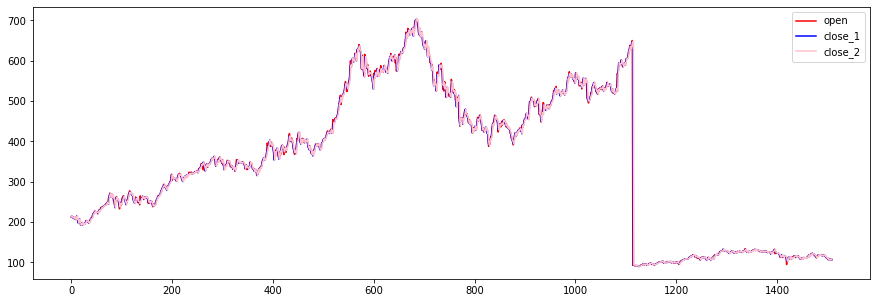

In [43]:
#Plotting to check everything's working fine

plt.figure(figsize=(15, 5));
plt.plot(X_train.open.values, color='red', label='open')
plt.plot(X_train.close_1.values, color='blue', label='close_1')
plt.plot(X_train.close_2.values, color='pink', label='close_2')
plt.legend(loc='best')
plt.show()

In [44]:
#getting the date as a feature
X_train['date'] = X_train['date'].dt.strftime('%Y%m%d').astype(float)
X_test['date'] = X_test['date'].dt.strftime('%Y%m%d').astype(float)

In [45]:
#Normalizing the data again

def normalize_data(data):
    min_max_scaler = MinMaxScaler()
    data["open"] = min_max_scaler.fit_transform(data.open.values.reshape(-1,1))
    data["close_1"] = min_max_scaler.fit_transform(data.close_1.values.reshape(-1,1))
    data["close_2"] = min_max_scaler.fit_transform(data.close_2.values.reshape(-1,1))
    data["date"] = min_max_scaler.fit_transform(data.date.values.reshape(-1,1))
    
    return data

In [46]:
X_train = normalize_data(X_train)
X_test = normalize_data(X_test)

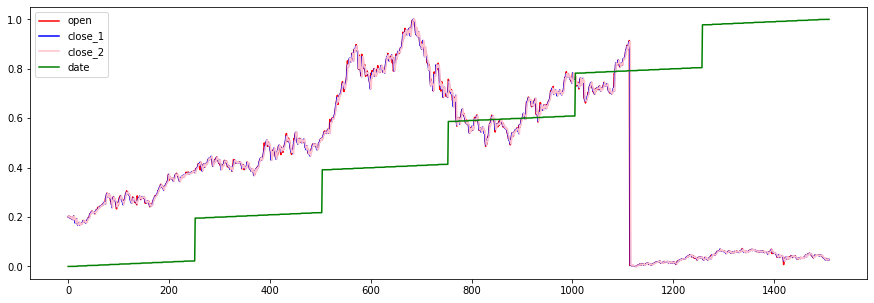

In [47]:
plt.figure(figsize=(15, 5));
plt.plot(X_train.open.values, color='red', label='open')
plt.plot(X_train.close_1.values, color='blue', label='close_1')
plt.plot(X_train.close_2.values, color='pink', label='close_2')
plt.plot(X_train.date.values, color='green', label='date')
plt.legend(loc='best')
plt.show()

In [48]:
#Everything looks good. Checking the shape
print(X_train.shape , Y_train.shape)
print("="*50)
print(X_test.shape, Y_test.shape)

(1510, 4) (1510,)
(252, 4) (252,)


__LSTM Model__

In [49]:
X_train = X_train.values.reshape(X_train.shape[0] , 1 , X_train.shape[1])
X_test = X_test.values.reshape(X_test.shape[0] , 1 , X_test.shape[1])

In [50]:
# create the model
#Setting the best set of parameters

model = Sequential()

model.add(GRU(256, input_shape = (1 , 4) , return_sequences = True))
model.add(Dropout(0.4))

model.add(LSTM(256))
model.add(Dropout(0.4))

#model.add(LSTM(128))
#model.add(Dropout(0.4))

model.add(Dense(64 ,  activation = 'relu'))
model.add(Dense(1))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 1, 256)            200448    
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 256)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 742,273
Trainable params: 742,273
Non-trainable params: 0
_________________________________________________________________
None

In [51]:
model.compile(loss='mean_squared_error', optimizer=Adam(lr = 0.001) , metrics = ['mean_squared_error'])

In [52]:
model_lstm  = model.fit(X_train, Y_train , epochs=150 , batch_size = 128 , validation_data = (X_test, Y_test))

Train on 1510 samples, validate on 252 samples
Epoch 1/150
1510/1510 [==============================] - 2s 1ms/step - loss: 152183.2622 - mean_squared_error: 152183.2622 - val_loss: 10795.2759 - val_mean_squared_error: 10795.2759
Epoch 2/150
1510/1510 [==============================] - 0s 101us/step - loss: 150571.2497 - mean_squared_error: 150571.2497 - val_loss: 9810.7285 - val_mean_squared_error: 9810.7285
Epoch 3/150
1510/1510 [==============================] - 0s 93us/step - loss: 144018.0151 - mean_squared_error: 144018.0151 - val_loss: 6854.4936 - val_mean_squared_error: 6854.4936
Epoch 4/150
1510/1510 [==============================] - 0s 95us/step - loss: 127127.0318 - mean_squared_error: 127127.0318 - val_loss: 2174.6507 - val_mean_squared_error: 2174.6507
Epoch 5/150
1510/1510 [==============================] - 0s 93us/step - loss: 98088.8107 - mean_squared_error: 98088.8107 - val_loss: 320.4065 - val_mean_squared_error: 320.4065
Epoch 6/150
1510/1510 [======================

Epoch 46/150
1510/1510 [==============================] - 0s 94us/step - loss: 887.8373 - mean_squared_error: 887.8373 - val_loss: 110442.8683 - val_mean_squared_error: 110442.8683
Epoch 47/150
1510/1510 [==============================] - 0s 95us/step - loss: 848.3416 - mean_squared_error: 848.3416 - val_loss: 109181.8465 - val_mean_squared_error: 109181.8465
Epoch 48/150
1510/1510 [==============================] - 0s 88us/step - loss: 917.9651 - mean_squared_error: 917.9651 - val_loss: 110568.0260 - val_mean_squared_error: 110568.0260
Epoch 49/150
1510/1510 [==============================] - 0s 97us/step - loss: 844.1939 - mean_squared_error: 844.1939 - val_loss: 109195.0565 - val_mean_squared_error: 109195.0565
Epoch 50/150
1510/1510 [==============================] - 0s 95us/step - loss: 829.4784 - mean_squared_error: 829.4784 - val_loss: 111943.5737 - val_mean_squared_error: 111943.5737
Epoch 51/150
1510/1510 [==============================] - 0s 100us/step - loss: 793.0184 - mean

1510/1510 [==============================] - 0s 98us/step - loss: 707.4989 - mean_squared_error: 707.4989 - val_loss: 109202.9874 - val_mean_squared_error: 109202.9874
Epoch 92/150
1510/1510 [==============================] - 0s 95us/step - loss: 742.4285 - mean_squared_error: 742.4285 - val_loss: 108897.6902 - val_mean_squared_error: 108897.6902
Epoch 93/150
1510/1510 [==============================] - 0s 86us/step - loss: 777.8177 - mean_squared_error: 777.8177 - val_loss: 115350.9988 - val_mean_squared_error: 115350.9988
Epoch 94/150
1510/1510 [==============================] - 0s 102us/step - loss: 760.6776 - mean_squared_error: 760.6776 - val_loss: 112711.1550 - val_mean_squared_error: 112711.1550
Epoch 95/150
1510/1510 [==============================] - 0s 94us/step - loss: 713.5696 - mean_squared_error: 713.5696 - val_loss: 111699.1424 - val_mean_squared_error: 111699.1424
Epoch 96/150
1510/1510 [==============================] - 0s 93us/step - loss: 685.7760 - mean_squared_erro

1510/1510 [==============================] - 0s 88us/step - loss: 697.4280 - mean_squared_error: 697.4280 - val_loss: 111804.6726 - val_mean_squared_error: 111804.6726
Epoch 137/150
1510/1510 [==============================] - 0s 94us/step - loss: 633.1996 - mean_squared_error: 633.1996 - val_loss: 107152.1739 - val_mean_squared_error: 107152.1739
Epoch 138/150
1510/1510 [==============================] - 0s 90us/step - loss: 636.7908 - mean_squared_error: 636.7908 - val_loss: 106519.6823 - val_mean_squared_error: 106519.6823
Epoch 139/150
1510/1510 [==============================] - 0s 91us/step - loss: 651.5427 - mean_squared_error: 651.5427 - val_loss: 110943.7780 - val_mean_squared_error: 110943.7780
Epoch 140/150
1510/1510 [==============================] - 0s 88us/step - loss: 636.3634 - mean_squared_error: 636.3634 - val_loss: 112635.4556 - val_mean_squared_error: 112635.4556
Epoch 141/150
1510/1510 [==============================] - 0s 91us/step - loss: 652.7656 - mean_squared_

In [53]:
#Checking the scores

def model_score(model, X_train, Y_train, X_test, Y_test):
    trainScore = model.evaluate(X_train, Y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))
    testScore = model.evaluate(X_test, Y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

model_score(model, X_train, Y_train, X_test, Y_test)

Train Score: 70.06348 MSE (8.37 RMSE)
Test Score: 110846.07788 MSE (332.94 RMSE)


(70.06347737217581, 110846.07787698413)

In [54]:
y_pred = model.predict(X_test)

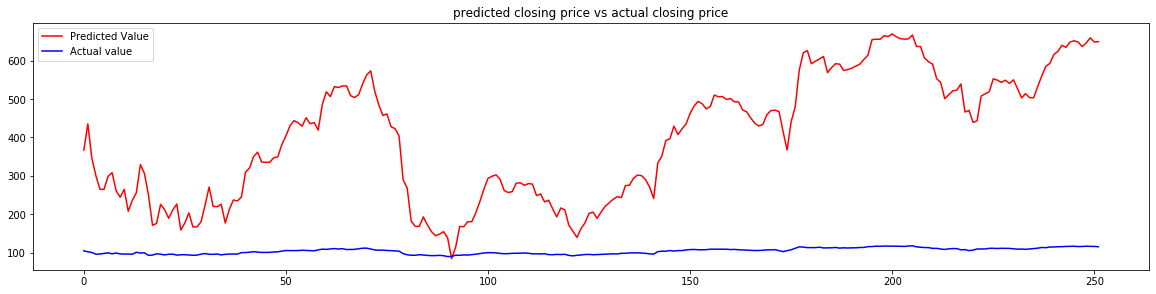

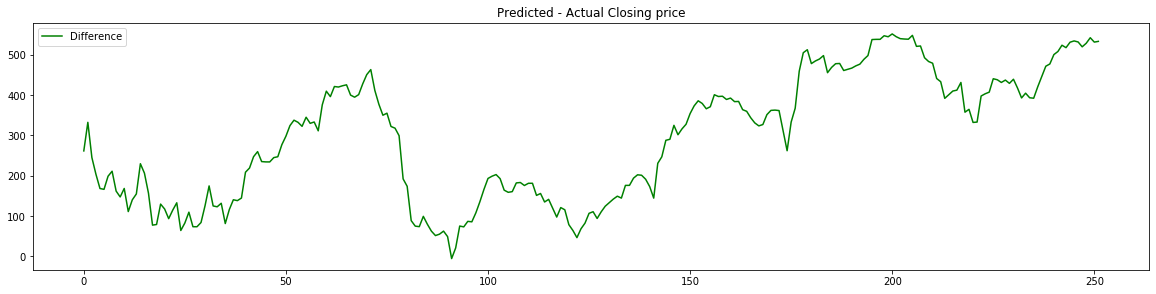

In [55]:
#Plotting the actual vs the predicted closing price values
#Plotting the difference between the predicted and the actual value
from pylab import *

figure(figsize=(20,10))
subplot(2,1,1)
title('predicted closing price vs actual closing price')
plot(y_pred , color = 'r' , label = 'Predicted Value')
plot(Y_test , color = 'b' , label = 'Actual value')
legend()

figure(figsize=(20,10))
subplot(2,1,2)
title('Predicted - Actual Closing price')
plot(y_pred.flatten()-Y_test , color = 'g' , label = 'Difference')

legend()
show()

__Conclusion__


Scores have slightly improved after changing some features. Still for a LSTM model (which usually works good for Time series forecasting), the scores are very poor